In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from tqdm import tqdm

import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('ggplot')

# Read and prepare Data first

In [3]:
# exported to read_dataset, will drop all MC features and stuff
from data_preparation import read_dataset
DATA, LABELS = read_dataset()

In [4]:
# store complete dataset and randomize entries for MRMR
if False:
    full_df = pd.concat([LABELS, DATA], axis=1)
    filename = './data/full_dataset.csv'
    idxs = np.arange(len(full_df))
    np.random.shuffle(idxs)
    full_df.iloc[idxs].to_csv(filename, index=False)

In [5]:
# see http://penglab.janelia.org/proj/mRMR/#c++ for the implementation
# !cat data/mrmr_output.txt

# just get the results
mrmr_order, mrmr_feature_index, mrmr_feature_name, mrmr_score = np.genfromtxt('./data/mrmr_output.txt',
                                                                              unpack=True,
                                                                              skip_header=6,
                                                                              max_rows=50,)

In [6]:
# mrmr_best_30 = DATA[DATA.columns[mrmr_feature_index[:30]]]
mrmr_best_30 = DATA.columns[mrmr_feature_index[:30].astype(int)]

100%|██████████| 125/125 [00:17<00:00,  8.21it/s]


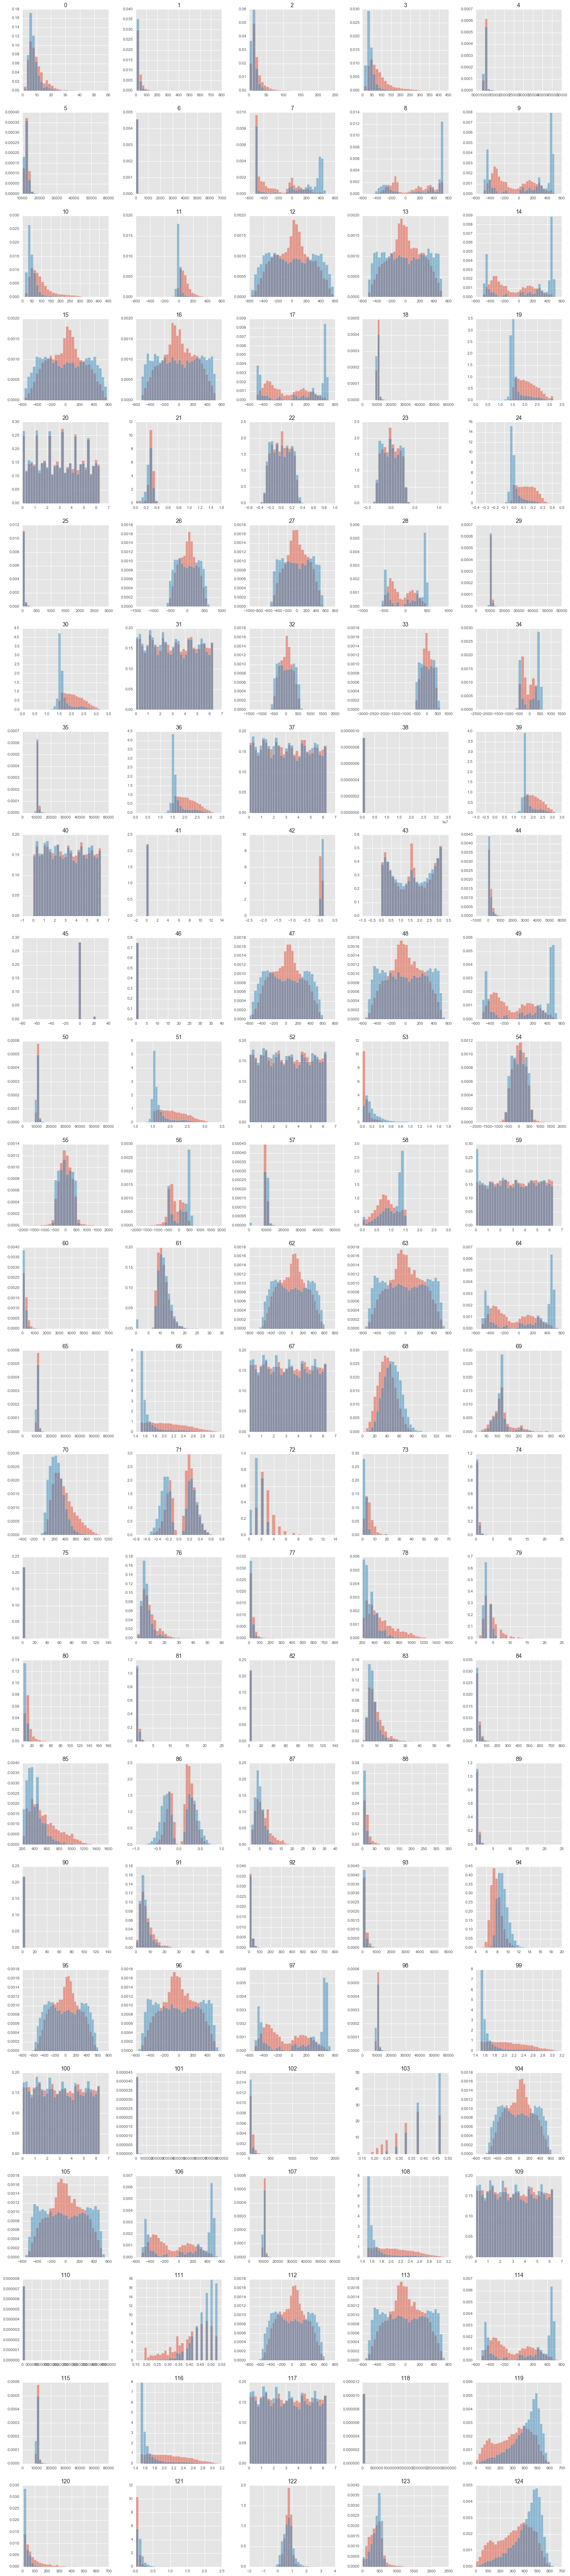

In [7]:
# Plot features, we have 157 of them this will probably take a while
plt.figure(figsize=(20, 90))
for i, feature in tqdm(enumerate(DATA.columns), total=len(DATA.columns)):
    plt.subplot(np.ceil(len(DATA.columns) / 5), 5, i+1)
    _, bins = np.histogram(DATA[feature], 30)
    plt.hist(DATA[LABELS==1][feature], bins=bins, alpha=0.5, normed=True)
    plt.hist(DATA[LABELS==0][feature], bins=bins, alpha=0.5, normed=True)
    plt.title(i)
plt.tight_layout()
plt.show()

In [8]:
gb = GradientBoostingClassifier()

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(DATA, LABELS, test_size=0.3)
gb.fit(train_data, train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [10]:
proba = gb.predict_proba(test_data)[:,1]
score = roc_auc_score(test_labels, proba)
score

0.9950896800467689

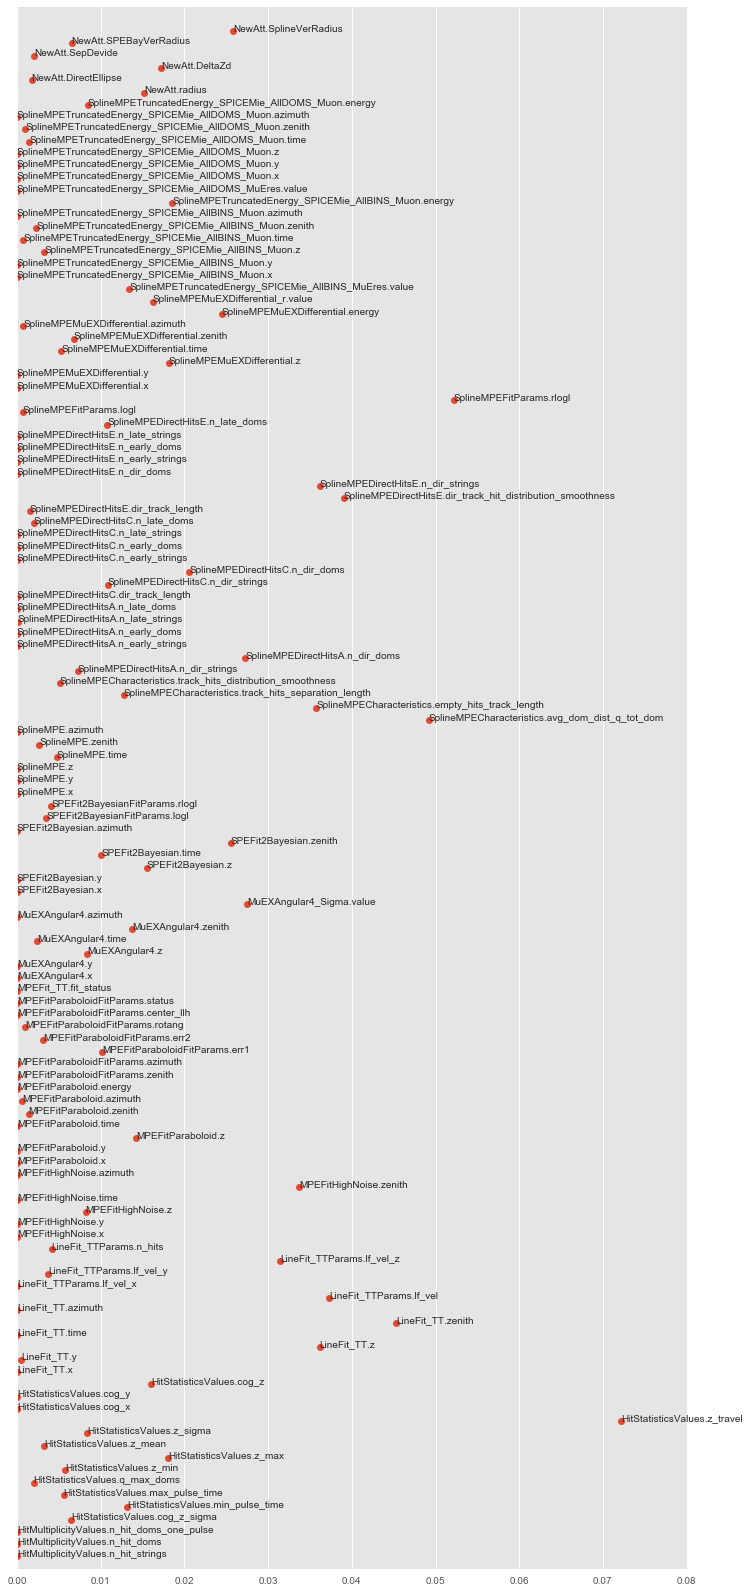

In [11]:
plt.figure(figsize=(12,28))
fis = gb.feature_importances_
plt.plot(fis, range(len(DATA.columns)), 'o')
for i, f in enumerate(DATA.columns):
    plt.annotate(f, (fis[i], i))
plt.yticks([])
plt.ylim(-1, len(DATA.columns) + 1)
plt.show()